<a href="https://colab.research.google.com/github/BSniegowski/ML-uni_course/blob/main/project/mdd_eeg_diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Download and unzip data
!wget https://figshare.com/ndownloader/articles/4244171/versions/2
!unzip 2
!pip install mne

In [1]:
#@title load files
import os
import mne

mne.set_log_level('ERROR')


raws = []
for file in os.scandir('.'):
  _, ext = os.path.splitext(file.path)
  if ext == ".edf":
    raws.append(mne.io.read_raw_edf(file.path))

In [2]:
#@title Dataset class
import torch
from torch.utils.data import Dataset

# ignoring timestamps - treating data as sequences

class CustomDataset(Dataset):
  def __init__(self, raws, transform=None, segment_length=60):
    self.segment_length = segment_length
    self.data = []
    self.labels = []
    for raw in raws:
      label = 1 if "MDD" in raw.filenames[0] else 0
      data = torch.squeeze(torch.as_tensor(raw.load_data()[:20,:][0]))
      length_seconds = data.size()[1]/256
      i=0
      while (i+1)*segment_length < length_seconds:
        x = data[:,i*segment_length*256:(i+1)*segment_length*256]
        self.data.append(x)
        self.labels.append(label)
        i += 1

    self.transform = transform

  def __len__(self):
    return len(self.labels)

  def __getitem__(self,idx):
    X, y = self.data[idx], self.labels[idx]
    if self.transform is not None:
      X = self.transform(X)
    X = torch.as_tensor(X[None, ...])
    return X, y

In [3]:
#@title DataLoaders
from torch.utils.data import random_split, DataLoader


dataset = CustomDataset(raws, transform=torch.nn.functional.normalize, segment_length=60)

train_dataset, test_dataset = random_split(dataset, [0.8, 0.2])
train_batch_size = 4
test_batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, drop_last=True)

In [4]:
#@title show results
def show_results(logs):
  f, ax = plt.subplots(1, 2, figsize=(16, 5))
  ax[0].plot(logs['train_accuracy'], color='b', linestyle='--', label='train')
  ax[0].plot(logs['test_accuracy'], color='g', label='test')
  ax[0].set_xlabel('epochs')
  ax[0].set_ylabel('accuracy')
  ax[0].legend()

  ax[1].plot(logs['train_loss'], color='b', linestyle='--', label='train')
  ax[1].plot(logs['test_loss'], color='g', label='test')
  ax[1].set_xlabel('epochs')
  ax[1].set_ylabel('loss')
  ax[1].legend()

In [5]:
#@title train loop
from torch import nn
import matplotlib.pyplot as plt

bad_data = None

def train(model, optimizer, loss_fn, learning_rate, n_epochs, logs, scheduler):
  model.train()

  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  correct, numel = 0, 0

  for i in range(n_epochs):
    model.train()

    for x, y in train_loader:
      x = x.to(device)
      y = y.to(device)
      optimizer.zero_grad()
      bad_data = x
      output = model(x)
      output = torch.squeeze(output)
      y_pred = output > 0.5
      correct += torch.sum(y_pred == y).item()
      numel += train_loader.batch_size
      y = y.double()
      loss = loss_fn(output, y)
      loss.backward()
      optimizer.step()

    if scheduler is not None:
      scheduler.step(loss)
      print(optimizer.param_groups[0]['lr'])
    logs['train_loss'].append(loss.item())
    logs['train_accuracy'].append(correct / numel)
    correct, numel = 0, 0

    model.eval()
    with torch.no_grad():
      for x_test, y_test in test_loader:
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        bad_data = x_test
        output = model(x_test)
        output = torch.squeeze(output)
        y_pred = output > 0.5
        correct += torch.sum(y_pred == y_test).item()
        numel += test_loader.batch_size
      y_test = y_test.double()
      loss = loss_fn(output, y_test)

    logs['test_loss'].append(loss.item())
    logs['test_accuracy'].append(correct / numel)
    correct, numel = 0, 0
    show_results(logs)
    plt.pause(1e-10)

In [ ]:
#@title ConvModel
from torch import nn
class ConvModel(nn.Module):
  def __init__(self):
    super(ConvModel, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=5, stride=3, padding=3),
        nn.BatchNorm2d(num_features=32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=1),
        nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(num_features=32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=1),
    )
    self.adaptivepool = nn.AdaptiveAvgPool2d((20, 64))
    self.classifier = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(32*20*64, 1),
        nn.Sigmoid()
    )
    
  def forward(self, x):
    x = self.conv(x)
    x = self.adaptivepool(x)
    x = torch.flatten(x, start_dim=1)
    x = self.classifier(x)
    return x


model = ConvModel()
model.double()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Device: ", device)
model.to(device)
loss_fn = nn.BCELoss()
n_epochs = 50
LR = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

logs = {'train_loss': [], 'test_loss': [], 'train_accuracy': [], 'test_accuracy': []}
train(model, optimizer, loss_fn, LR, n_epochs, logs, scheduler)

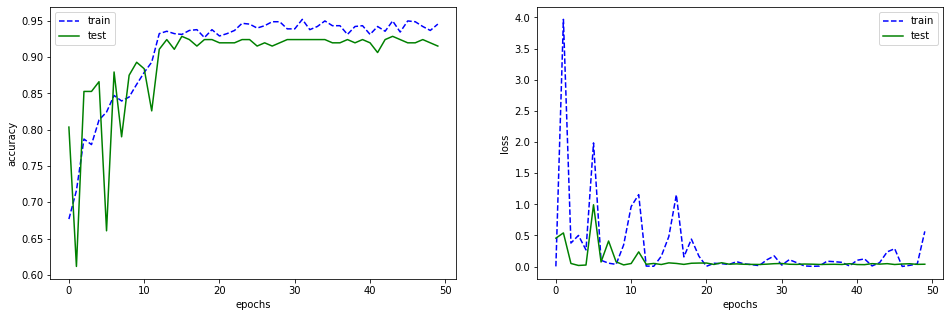

In [14]:
show_results(logs)

In [6]:
#@title Dataloaders for RNN model
from torch.utils.data import random_split, DataLoader, Subset
dataset = CustomDataset(raws, transform=torch.nn.functional.normalize, segment_length=1)
dataset = Subset(dataset, [i for i in torch.randint(0,len(dataset),(len(dataset)//2,))])

train_dataset, test_dataset = random_split(dataset, [0.8, 0.2])
train_batch_size = 4
test_batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, drop_last=True)

In [ ]:
#@title RNNmodel
class RNNmodel(nn.Module):
  def __init__(self, hidden_size, segment_length):
    super(RNNmodel, self).__init__()
    self.segment_length = segment_length
    self.conv = nn.Sequential(
        nn.Conv2d(1, 1, kernel_size=5, stride=1, padding=3),
        nn.BatchNorm2d(num_features=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=1),
    )
    input_size = 20 # our data comes from 20 electrodes
    self.rnn = nn.GRU(input_size, hidden_size, batch_first=True)
    self.classifier = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(hidden_size, 1),
        nn.Sigmoid()
    )

  def forward(self, x):
    x = self.conv(x)
    x = torch.squeeze(x) # reduce channel dimension equal to 1
    # reshape to (batch_size, sequence_length, input_size)
    x = torch.reshape(x, (x.size()[0], x.size()[2], -1))
    x, hidden = self.rnn(x)
    x = x[:,-1] # take only last output
    x = self.classifier(x)
    return x

hidden_size = 32
segment_length = 1
rnn_model = RNNmodel(hidden_size, segment_length)
rnn_model.double()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Device: ", device)
rnn_model.to(device)
loss_fn = nn.BCELoss()
LR = 0.01
n_epochs = 100
optimizer = torch.optim.SGD(rnn_model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

logs2 = {'train_loss': [], 'test_loss': [], 'train_accuracy': [], 'test_accuracy': []}
train(rnn_model, optimizer, loss_fn, LR, n_epochs, logs2, scheduler)

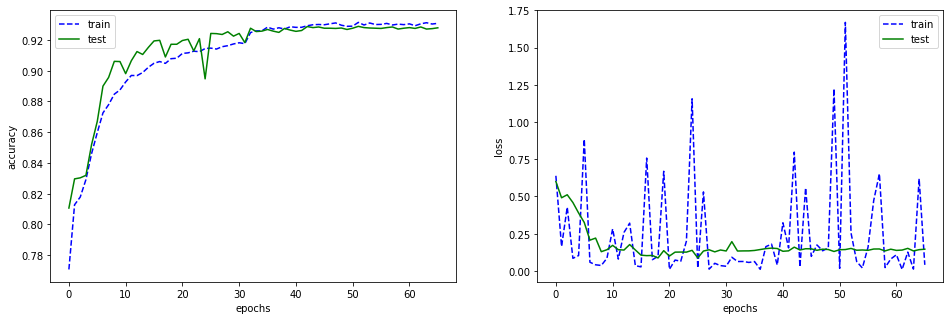

In [9]:
show_results(logs2)

In [15]:
#@title save model architecture and performance
from datetime import datetime

timestamp = datetime.now()
test_acc = max(logs['test_accuracy']) * 100
test_loss = min(logs['test_loss'])
train_acc = max(logs['train_accuracy']) * 100
train_loss = min(logs['train_loss'])
!echo "timestamp: $timestamp, test acc: $test_acc, test loss: $test_loss" >> ./performance_history.txt
!echo "train acc: $train_acc, train loss: $train_loss" >> ./performance_history.txt
!echo "$model.__dict__['_modules']" >> ./performance_history.txt
!echo "$optimizer" >> ./performance_history.txt
!echo "train batch: $train_batch_size, test batch: $test_batch_size" >> ./performance_history.txt
!echo "$logs" >> ./performance_history.txt
!echo "" >> ./performance_history.txt
!echo "" >> ./performance_history.txt